In [1]:
# Not all of these will be used, remove as needed
import os
import matplotlib.pyplot as plt
from IPython.display import display
from ipywidgets import interact, widgets
import numpy as np
import pandas as pd
from aicsimageio import AICSImage
from scipy.signal import find_peaks
from scipy.optimize import curve_fit
from scipy.ndimage import binary_dilation
from scipy.signal import butter, filtfilt
from tqdm import tqdm
from skimage import io, filters, morphology
from skimage.util import img_as_ubyte, img_as_float, img_as_uint
from skimage.filters import rank
from skimage.color import rgb2gray
from skimage.morphology import disk
from skimage.io import imsave
import cv2
from skimage import measure, feature, color
from skimage.draw import disk
from skimage.feature import blob_dog, blob_log, blob_doh
import heapq

In [2]:
# List of files for Dan to test
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_1_2024-01-11_Confocal_01.00.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_2_2024-01-11_Confocal_01.16.28_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD 0.5 um_3_2024-01-11_Confocal_01.08.43_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_1_2024-01-11_Confocal_01.23.49_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_2_2024-01-11_Confocal_01.30.50_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/PBP4 1.2OD 0.5 um_3_2024-01-11_Confocal_01.40.34_DragonflyUser.ims'

# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous_2024-01-10_Confocal_22.39.44_DragonflyUser.ims'
# '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 2_2024-01-10_Confocal_22.46.39_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT DNase_2024-04-18_Confocal_00.55.19_DragonflyUser.ims'

# '/Users/moose/Downloads/Controls 20240418/WT 1 window_2024-04-18_Confocal_00.33.17_DragonflyUser_FusionStitcher.ims' Do not use!

# '/Users/moose/Downloads/Controls 20240418/WT 1 stack_2024-04-18_Confocal_00.48.57_DragonflyUser.ims' Good test stack for budding events, slightly tilted.

In [3]:
# Load raw ims file here

file_name = '/Users/moose/Downloads/1.2 OD TraCE 1 01112024/WT 1.2OD Nonporous 2_2024-01-10_Confocal_22.46.39_DragonflyUser.ims'
image = AICSImage(file_name)
image_data = image.get_image_data("ZYX", S=0, T=0, C=0)

SLF4J: No SLF4J providers were found.
SLF4J: Defaulting to no-operation (NOP) logger implementation
SLF4J: See https://www.slf4j.org/codes.html#noProviders for further details.


In [4]:
# Global variables
key_frame = '/Users/moose/Desktop/trace_ca-local/key-frame-ca-norm2.tif'
key_img = io.imread(key_frame)
norm_flat = key_img # Need to fix in code for clarity, this variable is redundant.

# Some of these are not used, remove later
DoG_thresh = 0.3
lowerbound = 2
search_mod = 25
z_project = 10

BlurToggle = False
gkernal = (21, 21)

DilateToggle = False
dstructure = np.ones((3, 3))

In [5]:
# All functions
def subtractflatfield(input_img):
    grayscale_img = input_img
    poly2d_fcn = lambda xy, a, b, c, d, e, f: a + b*xy[0] + c*xy[1] + d*xy[0]*xy[0] + e*xy[1]*xy[1] + f*xy[0]*xy[1]

    y, x = np.indices(grayscale_img.shape)

    x_co = x.flatten()
    y_co = y.flatten()
    pix_val = grayscale_img.flatten()

    p0 = [1, 1, 1, 1, 1, 1]
    popt, _ = curve_fit(poly2d_fcn, (x_co, y_co), pix_val, p0=p0) 
    flat_field_img = poly2d_fcn((x_co, y_co), *popt).reshape(grayscale_img.shape)
    fit_img = grayscale_img - (flat_field_img)

    return fit_img

def background_subtract(img_dat):
    x1 = np.min(img_dat)
    x2 = []
    for i in range(len(img_dat)):
        x2.append(img_dat[i] - x1)

    x2 = np.maximum(x2, 0)

    return x2

def means_match(input_img, kfimg):
        # kfmod = subtractflatfield(kfimg)
        # kfmod = kfmod-np.min(kfmod)
        kfmod = kfimg
        kfmean = np.mean(kfmod)

        # xmod_loss = []

        best_mean_diff = np.inf
        best_xmod = 0
        mean_diff = 0
        bftest = input_img
        bfmin = np.min(bftest)
            
        for xmod in tqdm(np.linspace(0.01, 10, 500), desc='Means Matching'):
            xmodtest = np.clip(xmod * (bftest), np.min(kfimg), np.max(kfimg))
            mean_xmodtest = np.mean(xmodtest)
            mean_diff = abs(mean_xmodtest - kfmean)

            # xmod_loss = mean_diff # Diagnostic
                
            if mean_diff < best_mean_diff:
                best_mean_diff = mean_diff
                best_xmod = xmod

            if mean_diff < 0.0005:
                print(f'Image is at an acceptable target, stopping iterations')
                break

            bfimg = np.clip(best_xmod * (input_img - np.min(input_img)), np.min(kfimg), np.max(kfimg))

        return bfimg, kfmod, best_xmod

In [6]:
flattened_im_data = []
for i in tqdm(range(len(image_data)), desc='Removing background from stack'):
    flattened_im_data.append(subtractflatfield(image_data[i]))

Removing background from stack: 100%|██████████| 290/290 [01:57<00:00,  2.46it/s]


In [7]:
# Initial image processing
frame_mean = []
frame_min = []
frame_max = []
frame_std = []
frame_95 = []
frame_05 = []
for i in range(len(image_data)):
    frame_mean.append(np.mean(image_data[i]))
    frame_min.append(np.min(image_data[i]))
    frame_max.append(np.max(image_data[i]))
    frame_std.append(np.std(image_data[i]))
    frame_95.append(np.percentile(image_data[i], 95))
    frame_05.append(np.percentile(image_data[i], 5))

plusband = []
minusband = []
for i in range(len(image_data)):
    plusband.append(frame_mean[i] + frame_std[i])
    minusband.append(frame_mean[i] - frame_std[i])

frame_mean_top = []
frame_mean_bottom = []
for i in range(len(image_data)//2):
    frame_mean_bottom.append(frame_mean[i])

for i in range(len(image_data)//2, len(image_data)):
    frame_mean_top.append(frame_mean[i])

In [8]:
# Peak detection
background_collect = background_subtract(frame_mean)
peaks2, _ = find_peaks(background_collect, height = 1)
print(peaks2)

[286]


In [9]:
# Generate ensemble model for focus measure voting
hist_key = {}

for i in range(peaks2[0]-search_mod, peaks2[0]):
    if i > 0:
        hist_key[i] = image_data[i]

for i in range(peaks2[0], peaks2[0]+search_mod+1):
    if i < len(image_data):
        hist_key[i] = image_data[i]

hist_stdev = {}
for i in hist_key.keys():
    hist_stdev[i] = np.std(hist_key[i])

hist_laplace = {}
hist_laplace_focusemeasure = {}
for i in hist_key.keys():
    hist_laplace[i] = cv2.Laplacian(hist_key[i], cv2.CV_64F)
    hist_laplace_focusemeasure[i] = np.var(hist_laplace[i])

hist_tenengrad_focusemeasure = {}
hist_squared_grad = {}
for i in hist_key.keys():
    sobelx = cv2.Sobel(hist_key[i], cv2.CV_64F, 1, 0, ksize=5)
    sobely = cv2.Sobel(hist_key[i], cv2.CV_64F, 0, 1, ksize=5)

    magnitude = np.sqrt(sobelx**2 + sobely**2)
    squared_grad = (sobelx**2 + sobely**2)

    hist_tenengrad_focusemeasure[i] = np.var(magnitude)
    hist_squared_grad[i] = np.var(squared_grad)


hist_brenner_focusemeasure = {}
for i in hist_key.keys():
    shifted_right = np.roll(hist_key[i], -1, axis=1)
    shifted_down = np.roll(hist_key[i], -1, axis=0)

    diff_right = (shifted_right - hist_key[i])[:-1, :-1] ** 2
    diff_down = (shifted_down - hist_key[i])[:-1, :-1] ** 2

    sum_diff = np.sum(diff_right) + np.sum(diff_down)
    hist_brenner_focusemeasure[i] = sum_diff

hist_max = {}
for i in hist_key.keys():
    hist_max[i] = np.max(hist_key[i])

In [10]:
# Finalize vote

weight_mat = [1, 1, 1, 1, 1, 1]
focus_margins = []

# stdev_two_largest = heapq.nlargest(2, hist_stdev.values())
# laplace_two_largest = heapq.nlargest(2, hist_laplace_focusemeasure.values())
# tenengrad_two_largest = heapq.nlargest(2, hist_tenengrad_focusemeasure.values())

stdev_stdev = np.std(list(hist_stdev.values()))
laplace_stdev = np.std(list(hist_laplace_focusemeasure.values()))
tenengrad_stdev = np.std(list(hist_tenengrad_focusemeasure.values()))
squared_grad_stdev = np.std(list(hist_squared_grad.values()))
brenner_stdev = np.std(list(hist_brenner_focusemeasure.values()))


weight_mat[0] = stdev_stdev/np.mean(list(hist_stdev.values()))
weight_mat[1] = laplace_stdev/np.mean(list(hist_laplace_focusemeasure.values()))
weight_mat[2] = tenengrad_stdev/np.mean(list(hist_tenengrad_focusemeasure.values()))
weight_mat[3] = squared_grad_stdev/np.mean(list(hist_squared_grad.values()))
weight_mat[4] = brenner_stdev/np.mean(list(hist_brenner_focusemeasure.values()))

focus_ensemble = []
focus_ensemble.append(max(hist_stdev, key=hist_stdev.get))
focus_ensemble.append(max(hist_laplace_focusemeasure, key=hist_laplace_focusemeasure.get))
focus_ensemble.append(max(hist_tenengrad_focusemeasure, key=hist_tenengrad_focusemeasure.get))
focus_ensemble.append(max(hist_squared_grad, key=hist_squared_grad.get))
focus_ensemble.append(max(hist_brenner_focusemeasure, key=hist_brenner_focusemeasure.get))

voting_power = []
for i in range(len(focus_ensemble)):
    voting_power.append((focus_ensemble[i], weight_mat[i]))

vote = {}
for frame_num, weighted_vote in voting_power:
    if frame_num in vote:
        vote[frame_num] += weighted_vote

    else:
        vote[frame_num] = weighted_vote

print(f'Final Vote - Membrane Layer at:  ' + str(max(vote, key=vote.get)))
mem_layer = max(vote, key=vote.get)

Final Vote - Membrane Layer at:  282


In [11]:
# Create z-projection

bud_test = []
for i in range(z_project):
    bud_test.append(mem_layer-i-1)

bud_test_img = []
for i in bud_test:
    bud_test_img.append(hist_key[i])

bud_composite = np.max(bud_test_img, axis=0)

bud_img = bud_composite

In [12]:
# Process z-projection and normalize brightness.
bud_norm = (bud_img - np.min(bud_img)) / (np.max(bud_img) - np.min(bud_img))
bud_norm = img_as_ubyte(bud_norm)

bud_sub = subtractflatfield(bud_img)
bud_sub = (bud_sub - np.min(bud_sub)) / (np.max(bud_sub) - np.min(bud_sub))
bud_sub = img_as_ubyte(bud_sub)  


bud_matched, kf_fin,  xtest = means_match(bud_sub, norm_flat)

Means Matching: 100%|██████████| 500/500 [00:04<00:00, 103.07it/s]


In [13]:
# Image processing for budding events
# Threshold image
bud_thresh = np.percentile(bud_matched, 98)
bud_brightest = np.where(bud_matched > bud_thresh, 256, 0)

# plt.figure(dpi=300)
# plt.imshow(bud_brightest, cmap='gray')
# plt.axis('off')
# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_binary.tif', dpi=500)
# plt.show()

# Morphological analysis
closed_im = morphology.closing(bud_brightest, morphology.square(1))
label_im = measure.label(closed_im)
region_im = measure.regionprops(label_im, intensity_image=bud_matched)
# for part in region_im:
#     print('Label: {} Area: {}'.format(part.label, part.area))

area_list = []
for part in region_im:
    area_list.append(part.area)

# delete_small_components = filters.threshold_otsu(np.array(area_list)) 
# area_list = [part for part in area_list if delete_small_components < part < 10000]

intensity_list = []
for part in region_im:
    intensity_list.append(part.mean_intensity)

int_cut = np.percentile(intensity_list, 50)
intensity_list = [part for part in intensity_list if  int_cut < part]

eccentricity_list = []
for part in region_im:
    eccentricity_list.append(part.eccentricity)

eccentricity_list = [part for part in eccentricity_list if 0.05 < part < 0.99]

area_list_thresh = np.percentile(area_list, 98)
mean_comp = np.percentile(intensity_list, 98)
# mean_comp = np.percentile(norm_flat, 99.8)
lower_ecc = np.percentile(eccentricity_list, 2)
higher_ecc = np.percentile(eccentricity_list, 98)

filter_area_low = area_list_thresh 
filter_eccentricity_low = lower_ecc
filter_eccentricity_high = higher_ecc
# region_im_filtered = [part for part in region_im if part.mean_intensity > mean_comp]
# region_im_filtered = [part for part in region_im_filtered if filter_area_low < part.area < 10000]
# region_im_filtered = [part for part in region_im_filtered if filter_eccentricity_low < part.eccentricity < filter_eccentricity_high]

region_im_filtered = [
                      part for part in region_im 
                      if part.mean_intensity > np.max([mean_comp, 150])
                      and np.max([filter_area_low, 15]) < part.area < 10000 
                      and filter_eccentricity_low < part.eccentricity < filter_eccentricity_high
                      ]

print('Raw Regions: {}'.format(len(region_im)))
print('Filtered Regions: {}'.format(len(region_im_filtered)))
for part in region_im_filtered:
    print('Centroid: ({:.0f}, {:.0f}) | Area: {} | Eccentricity {:.2f} | Mean Intensity {:.2f}'.format(part.centroid[0], part.centroid[1], part.area, part.eccentricity, part.mean_intensity))

Raw Regions: 10627
Filtered Regions: 46
Centroid: (150, 356) | Area: 36.0 | Eccentricity 0.78 | Mean Intensity 152.73
Centroid: (199, 842) | Area: 23.0 | Eccentricity 0.54 | Mean Intensity 162.42
Centroid: (216, 441) | Area: 21.0 | Eccentricity 0.51 | Mean Intensity 152.74
Centroid: (217, 1032) | Area: 17.0 | Eccentricity 0.77 | Mean Intensity 150.24
Centroid: (239, 327) | Area: 25.0 | Eccentricity 0.50 | Mean Intensity 162.44
Centroid: (281, 568) | Area: 38.0 | Eccentricity 0.93 | Mean Intensity 152.37
Centroid: (286, 387) | Area: 25.0 | Eccentricity 0.59 | Mean Intensity 157.64
Centroid: (373, 153) | Area: 80.0 | Eccentricity 0.80 | Mean Intensity 182.82
Centroid: (412, 543) | Area: 20.0 | Eccentricity 0.46 | Mean Intensity 156.37
Centroid: (424, 386) | Area: 21.0 | Eccentricity 0.72 | Mean Intensity 162.95
Centroid: (425, 903) | Area: 36.0 | Eccentricity 0.69 | Mean Intensity 170.63
Centroid: (436, 257) | Area: 21.0 | Eccentricity 0.61 | Mean Intensity 152.62
Centroid: (471, 938) | 

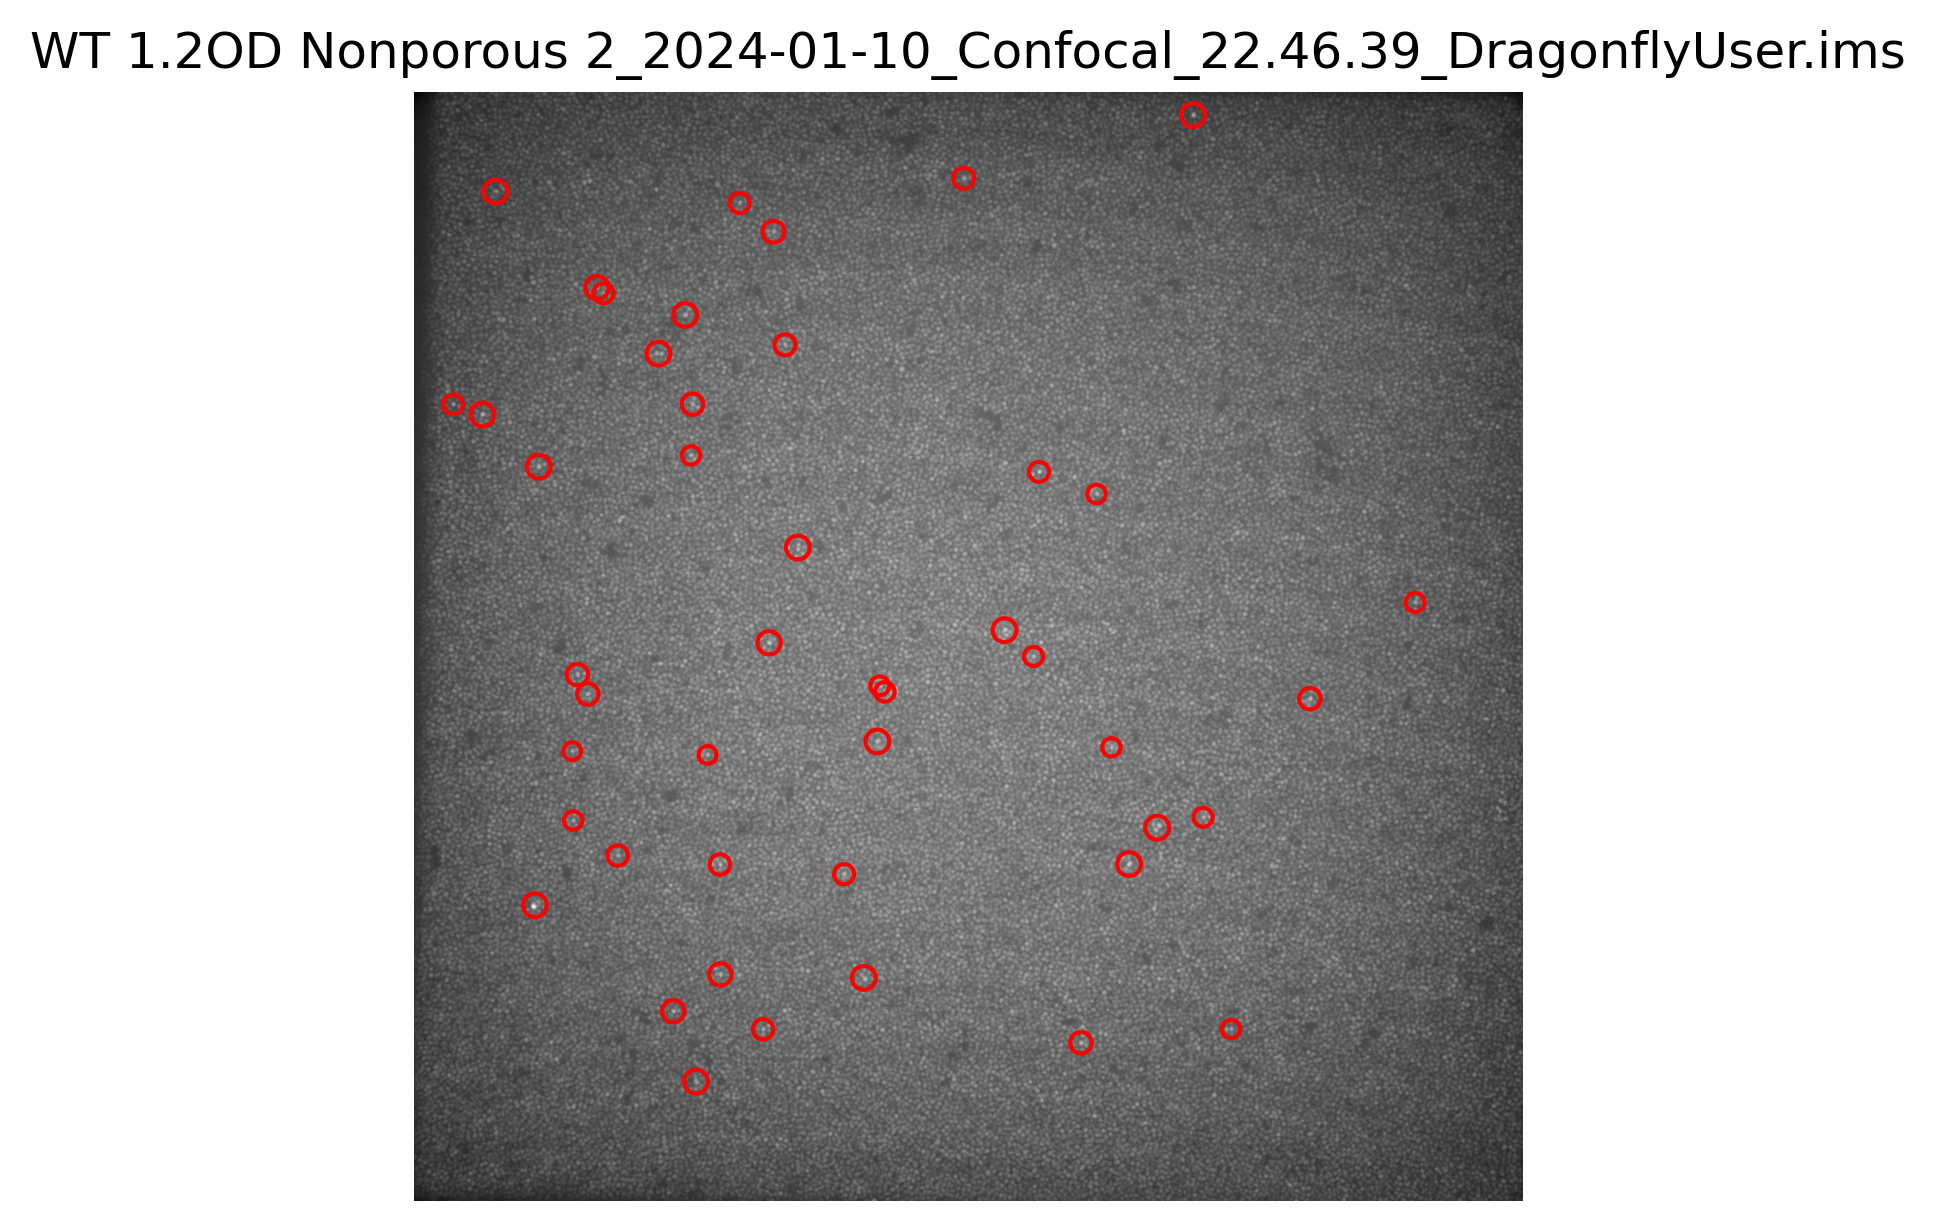

In [14]:
fig_alt, ax_alt = plt.subplots(dpi=300)
ax_alt.imshow(bud_img, cmap='gray')
for region in region_im_filtered:
    y, x = region.centroid
    radius = np.sqrt(region.area / np.pi)

    circle = plt.Circle((x, y), np.where(radius*5 < 15, radius*5, 15), fill=False, edgecolor='red')
    ax_alt.add_patch(circle)
   
ax_alt.invert_yaxis()
plt.axis('off')
plt.title(os.path.basename(file_name))
plt.show()

In [15]:
# print(f'File Name: ' + os.path.basename(file_name))
# bud_df = pd.DataFrame(blobs_dog, columns=['y-coord', 'x-coord', 'Radius'])
# bud_df.index.name = 'Bud ID'
# vote_array = [[k, v] for k, v in vote.items()]
# vote_df = pd.DataFrame(vote_array, columns=['Stack Layer', 'Vote Weight'])
# print(f'Membrane layer at: ' + str(mem_layer))
# print(f'Budding layer at: ' + str(bud_test[0]))
# print(f'Number of Detected Budding Events: ' + str(len(blobs_dog)))
# print('------------------------------')
# print('Final Vote Tally:')
# print(vote_df.to_string(index=False))
# print('------------------------------')
# print(bud_df)

In [16]:
# # Convert pandas dataframes and other variables to string and format it for display via matplotlb
# bud_df_str = bud_df.to_string()
# vote_df_str = vote_df.to_string(index=False)
# text = f"""File Name: {os.path.basename(file_name)}
# Membrane layer at: {mem_layer}
# Budding layer at: {bud_test[0]}
# Number of Detected Budding Events: {len(blobs_dog)}
# ------------------------------
# Final Vote Tally:
# {vote_df_str}
# ------------------------------
# {bud_df_str}"""

# fig = plt.figure(figsize=(9, 4))
# plt.text(0, 1, text, fontsize=12, verticalalignment='top')
# plt.axis('off')
# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_stats.png', dpi=500)
# plt.show()


# fig, ax = plt.subplots(figsize=(3, 3), dpi=500)
# ax.set_title('Detected Budding Events')
# ax.imshow(norm_flat, cmap='gray')
# for blob in blobs_dog:
#     y, x, r = blob
#     c = plt.Circle((x, y), r, color='green', linewidth=2, fill=False)
#     ax.add_patch(c)
#     ax.invert_yaxis()  # Invert the y-axis
# ax.set_axis_off()

# # plt.savefig('/Users/moose/Desktop/trace_ca-local/' + os.path.splitext(os.path.basename(file_name))[0] + '_detected.png', dpi=500)
# plt.show()